In [20]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.models import load_model
import tensorflow.keras.backend as K
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras
import os
from data_generation import *
from batch_creator import *
from gp_kernels import *
from gp_priors import *
from gp_plots import *

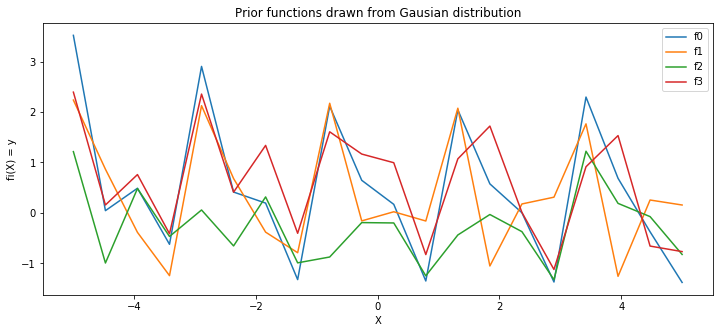

In [21]:
plot_gp_prior(4, n=20)

In [22]:
def create_batch_gp_mim_2(pos, tar, pos_mask, batch_s=128):
    '''
    '''
    shape = tar.shape[0]
    batch_idx_tr = np.random.choice(list(range(shape)), batch_s)
    batch_tar_tr = tar[batch_idx_tr, :]
    batch_pos_tr = pos[batch_idx_tr, :]
    batch_pos_mask = pos_mask[batch_idx_tr, :, :, :]
    return batch_tar_tr, batch_pos_tr, batch_pos_mask, batch_idx_tr

In [23]:
def data_generator_for_gp_mimick_gpt(num_obs, kernel, tr_percent=0.8):
    '''



    '''
    obs_per_sample = np.random.randint(20, 60, size = num_obs)
    df = np.zeros((num_obs * 2, np.max(obs_per_sample)))
    for i in range(0, num_obs * 2, 2):
        x = np.random.uniform(-5, 5, size=(1, obs_per_sample[int(i / 2)]))
        k = kernel(x)
        f_prior = generate_priors(k, obs_per_sample[int(i / 2)], 1)

        df[i, :x.shape[1]] = x
        df[i + 1, :x.shape[1]] = f_prior

    rows = df.shape[0]
    cols = df.shape[1]
    tr_rows = int(tr_percent * rows)
    tr_rows = tr_rows if tr_rows % 2 == 0 else tr_rows + 1
    df_tr = df[:tr_rows, :]
    df_te = df[tr_rows:, :]

    pad_pos_tr = df_tr[::2, :]
    pad_pos_te = df_te[::2, :]
    pad_y_fren_tr = df_tr[1::2, :]
    pad_y_fren_te = df_te[1::2, :]

    return pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te

In [24]:
def position_mask(batch):
    '''
    This tries to emulate the kernel matrix
    '''
    rows = batch.shape[0]
    cols = batch.shape[1]
    generic_mask = np.zeros((rows, cols, cols, cols))
    specific = np.sum(np.equal(batch, 0), 1)
    for i in range(2, cols + 1):
        generic_mask[:, i - 2, :i, :i] = np.ones((i, i))
    for j in range(rows):
#         print(specific[j])
        k  = specific[j]
        generic_mask[j, k:, :, :] = 0
            
    return generic_mask

In [25]:
def create_padding_mask(seq):
    '''
    
    
    '''
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention.
    return seq[:, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [26]:
def create_look_ahead_mask(size):
    '''
    
    
    '''
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    print(tf.shape(mask))
    return mask  # (seq_len, seq_len)

In [27]:
def create_masks(position, tar):
    '''
    -------------------
    Parameters: 
    position :
    tar :
    -------------------
    Returns: 
    combined_mask_pos :
    combined_mask_tar :
    '''
    
    pos_padding_mask = create_padding_mask(position)
    tar_padding_mask = create_padding_mask(tar)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    look_ahead_mask_pos = create_look_ahead_mask(tf.shape(position)[1])
    # if max seq length is 40 -- > this will be 40X40 
    ## this will be batch_size X 1 X 40
    
    ## This will also be (64, 40, 40)
    combined_mask_pos = tf.maximum(pos_padding_mask, look_ahead_mask_pos)
    combined_mask_tar = tf.maximum(tar_padding_mask, look_ahead_mask)
    
    
    return combined_mask_pos, combined_mask_tar

In [28]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te = data_generator_for_gp_mimick_gpt(10000, rbf_kernel)

In [29]:
pp = position_mask(pad_pos_tr)

In [66]:
# loss_object = tf.keras.losses.Loss()
optimizer = tf.keras.optimizers.Adam()

In [67]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [68]:
# Since the target sequences are padded, 
# it is important to apply a padding mask when calculating the loss.

In [96]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.square(tf.cast(real, tf.float32) - pred)
    
    print('loss_ :', loss_)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [88]:
def dot_prod_position(q, k, mask):
    '''
    
    '''
    matmul_qk = tf.matmul(q, k, transpose_a = True)
    nl_qk = tf.nn.relu(matmul_qk) 
    nl_qk = nl_qk[:, tf.newaxis, :, :]
    print('nl_qk: ', nl_qk)

    print('pos_mask:', mask)
    if mask is not None:
        nl_qk *= (tf.cast(mask, tf.float32))
    
    return nl_qk

In [97]:
def dot_product_attention(q, k, v, mask):
    '''
    
    '''
    # similarity
    # q = k = v  shape := (batch_size, max_seq_len - 1, max_seq_len -1)
    matmul_qk = tf.matmul(q, k, transpose_a = True)
#     print('matmul_qk: ', matmul_qk)
#     shape=(128, 58, 58)
    
    nl_qk = tf.nn.relu(matmul_qk) 
#     print('nl_qk: ', nl_qk)
#     shape=(128, 58, 58)
#     nl_qk shape := (batch_size, max_seq_len - 1, max_seq_len - 1)

    # -1e9 will turn the softmax output in this locations to zero
    # this is a good mask as an input for softmax -- we need also masking when 
    # want to use matmul as is 
    
    if mask is not None:
        nl_qk +=  (mask * -1e9)
    
        
#     print('nl_qk after mask: ', nl_qk)
#     shape=(128, 58, 58)
        
     # turn simialrity to scores
    attention_weights = tf.nn.softmax(nl_qk, axis = -1)
    
#     print('attention_weights: ', attention_weights)
#     shape=(128, 58, 58)
   
    # weight values 
    # attention_weights shape := (batch_size, max_seq_len - 1, max_seq_len - 1), 
    # v_transpose shape := max_seq_len X batch_size
    out_tar = tf.matmul(attention_weights, v, transpose_b = True)
    
#   print('out_tar: ', out_tar)
#   shape=(128, 58, 58)
    
    return out_tar, attention_weights, matmul_qk

In [98]:
def point_wise_feed_forward_network(dff):
    '''
    
    '''
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(1)  # (batch_size, seq_len, d_model)
  ])

In [99]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, pos_d_model, tar_d_model, rate, d_att, dff):
        super(Decoder, self).__init__()
        
        self.tar_d_model = tar_d_model

        self.wq = tf.keras.layers.Dense(pos_d_model)
        self.wk = tf.keras.layers.Dense(pos_d_model)
        self.wv = tf.keras.layers.Dense(pos_d_model)
                    
        
        self.hq = tf.keras.layers.Dense(tar_d_model)
        self.hk = tf.keras.layers.Dense(tar_d_model)
        self.hv = tf.keras.layers.Dense(tar_d_model)
        
        self.h_att = tf.keras.layers.Dense(d_att)
        
#         self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
#         self.dropout = tf.keras.layers.Dropout(rate)
        
        self.ffn = point_wise_feed_forward_network(dff)

    #a call method, the layer's forward pass
    def call(self, tar_position, tar_inp, training, pos_mask, tar_mask):
        
        tar_position = tar_position[:, :, tf.newaxis]
        
        q_p = self.wq(tar_position) 
        k_p = self.wk(tar_position)
#       print('q_p: ', q_p)
#       shape=(128, 59, 59) = (batch_size X max_seq_len X max_seq_len) 
        
        pos_attn1 = dot_prod_position(q_p, k_p, mask = pos_mask)
#       print('pos_attn1 :', pos_attn1)
#       shape=(128, 59, 59, 59)
        pos_attn1 = tf.reshape(pos_attn1, shape = [tf.shape(pos_attn1)[0] ,-1])
        # pos_attn1 is (batch_size, max_seq_len - 1, max_seq_len - 1)
    
        tar_inp = tar_inp[:, :, tf.newaxis]

        
        q = self.hq(tar_inp) 
        k = self.hk(tar_inp)
        v = self.hv(tar_inp)
        
#       print('q :', q)
#       shape=(128, 58, 58)

        tar_attn1, _, _ = dot_product_attention(q, k, v, tar_mask)
        # tar_attn1 is (batch_size, max_seq_len - 1, max_seq_len - 1)

#         print('tar_attn1 :', tar_attn1)
#         shape=(128, 58, 58)
        
        position = tf.reshape(self.h_att(pos_attn1), shape = [tf.shape(pos_attn1)[0], self.tar_d_model, self.tar_d_model])
                
        connector = tf.matmul(position, tar_attn1) 
        
#         print('connector :', connector)
#         shape=(128, 58, 58)

        out = tf.reshape(self.ffn(connector), shape = [tf.shape(connector)[0], tf.shape(connector)[1]])
        
#         print('out :', out)
#         shape=(128, 58)
        
        return out

In [100]:
decoder = Decoder(59, 58, 0.3, 58**2, 32)

In [101]:
@tf.function
def train_step(pos, tar, pos_mask):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    _, combined_mask_tar = create_masks(pos, tar_inp)

    
    with tf.GradientTape() as tape:
        pred = decoder(pos, tar_inp, True,pos_mask, combined_mask_tar)

        loss = loss_function(tar_real, pred)

    gradients = tape.gradient(loss, decoder.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)

In [102]:
tf.keras.backend.set_floatx('float32')

In [105]:
batch_tar_tr.shape

(128, 59)

In [103]:
if __name__ == '__main__':
    EPOCHS = 1
    batch_s  = 128
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    
    for epoch in range(EPOCHS):
        start = time.time()
        train_loss.reset_states()

        for batch in range(num_batches):
            batch_tar_tr, batch_pos_tr, batch_pos_mask, _ = create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, pp)
            # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
            # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
            train_step(batch_pos_tr, batch_tar_tr, batch_pos_mask)

            if batch % 50 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, train_loss.result()))

        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Tensor("Shape_1:0", shape=(2,), dtype=int32)
Tensor("Shape_3:0", shape=(2,), dtype=int32)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

q_p:  Tensor("decoder_8/dense_70/BiasAdd:0", shape=(128, 59, 59), dtype=float32)
nl_qk:  Tensor("decoder_8/strided_slice_1:0", shape=(128, 1, 59, 59), dtype=float32)
pos_mask: Tensor("pos_mask:0", shape=(128, 59, 59, 59), dtype=float64)
pos_attn1 : Tensor("decoder_8/mul:0", shape=(128, 59, 59, 59), dtype=float32)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this wa

KeyboardInterrupt: 

In [ ]:
tt[5000, 0,  1:, :]

In [ ]:
# tf.data.Dataset(tf.Tensor(pad_pos_tr, value_index = 0 , dtype = tf.float32))